# AccelerateAI: Logistic Regression

## Assumptions Check for LR

Following are assumptions of Logistic Regression (LIDAO):

* Linearity in the logit –should have a linear relationship with the logit form of the dependent variables, i.e. linearity of independent variables and log-odds
* Independence of observations
* Appropriate outcome type as Discrete (0, 1)
* Absence of perfect multicollinearity among the independent variables
* No strongly influential outliers


### Import Libraries and Load Dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import Logit, add_constant
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# A jupyter notebook specific command that let’s you see the plots in the notbook itself.
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/mishr/Desktop/Notebooks/data/CHD_Age.csv', index_col=0) 

df.sample(5)

,AGE,AGEGRP,CHD
ID,,,
20,33,2,0
90,59,7,1
71,53,6,1
29,36,3,1
4,25,1,0


In [3]:
df.shape

(100, 3)

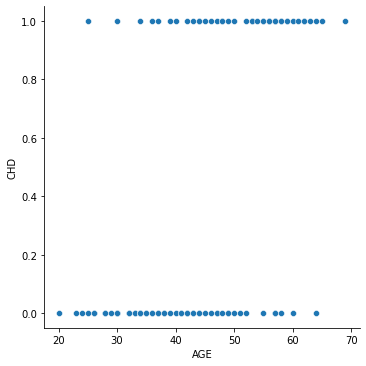

In [4]:
sns.relplot(data=df,x="AGE",y="CHD")
plt.show()

### Test with Logit Model

In [5]:
import statsmodels.api as sm

In [6]:
X = df[['AGE']]
y = df[['CHD']]

In [7]:
# Add constant term
X_constant = sm.add_constant(X, prepend=False)

log_reg = sm.Logit(y, X_constant).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.536765
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    CHD   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Sat, 04 Jun 2022   Pseudo R-squ.:                  0.2145
Time:                        00:44:02   Log-Likelihood:                -53.677
converged:                       True   LL-Null:                       -68.331
Covariance Type:            nonrobust   LLR p-value:                 6.168e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AGE            0.1109      0.024      4.610      0.000       0.064       0.158
const         -5.3095      1.

### 1. Check for Assumption: Linearity

* **In R: Box Tidwell Test - in-built method**
* **In Python: manually**

In [8]:
# Define continuous variables
continuous_var = ['AGE']

# Add logit transform interaction terms (natural log) for continuous variables e.g.. Age * Log(Age)
for var in continuous_var:
    df[f'{var}:Log_{var}'] = df[var].apply(lambda x: x * np.log(x))

# Keep columns related to continuous variables
cols_to_keep = continuous_var + df.columns.tolist()[-len(continuous_var):]

# Redefining variables to include interaction terms
X_lt = df[cols_to_keep]

# Add constant term
X_lt_constant = sm.add_constant(X_lt, prepend=False)

In [9]:
y = df[['CHD']]

In [10]:
# Building model and fit the data (using statsmodel's Logit)
logit_results = sm.GLM(y, X_lt_constant, family=sm.families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    CHD   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53.636
Date:                Sat, 04 Jun 2022   Deviance:                       107.27
Time:                        00:44:02   Pearson chi2:                     101.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
AGE            -0.1406      0.873     -0.161      

### 1. Check for Assumption: Linearity 

* **Visual Check**

In [11]:
# Re-running logistic regression on the original set of X and y variables
df = pd.read_csv('C:/Users/mishr/Desktop/Notebooks/data/CHD_Age.csv', index_col=0) 

df.head(3)

,AGE,AGEGRP,CHD
ID,,,
1,20,1,0
2,23,1,0
3,24,1,0


In [12]:
X = df[['AGE']]
y = df[['CHD']]

In [13]:
# Add constant term
X_constant = sm.add_constant(X, prepend=False)

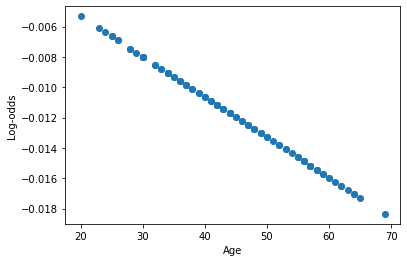

In [14]:
logit_results = sm.GLM(y, X, family=sm.families.Binomial()).fit()

predicted = logit_results.predict(X)

# Getting log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor variable vs logit values for Age
plt.scatter(x=X_constant['AGE'].values, y=log_odds)
plt.xlabel("Age")
plt.ylabel("Log-odds")
plt.show()

### 2. Check for Assumption: Independence of observations

The observations must be independent of each other, i.e., they should not come from repeated or paired data. This means that each observation is not influenced by or related to the rest of the observations.

This independence assumption is automatically met for our CHD AGE example dataset since the data consists of individual person records with CHD information

In [15]:
df['AGE'].unique()

array([20, 23, 24, 25, 26, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 69], dtype=int64)

### 3. Check for Assumption: Discrete Outcome

Appropriate outcome type as Discrete (0, 1)

We can check this assumption by getting the number of different outcomes in the dependent variable. If we want to use binary logistic regression, then there should only be two unique outcomes in the outcome variable.

In [16]:
df['CHD'].unique()

array([0, 1], dtype=int64)

### 4. Check for Assumption: Absence of Perfect Multicollinearity

Absence of perfect multicollinearity among the independent variables. Multicollinearity corresponds to a situation where the data contain highly correlated independent variables. This is a problem because it reduces the precision of the estimated coefficients, which weakens the statistical power of the logistic regression model.

Variance Inflation Factor (VIF) measures the degree of multicollinearity in a set of independent variables. Mathematically, it is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable.

In [17]:
# Use variance inflation factor to identify any significant multi-collinearity
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

In [18]:
calculate_vif(X_constant)

,variables,VIF
0,AGE,1.000000
1,const,15.480577


### 5. Check for Assumption: Influence + Outliers

No strongly influential outliers.
Logistic regression assumes that there are no highly influential outlier data points, as they distort the outcome and accuracy of the model.

In [19]:
# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(y, X_constant, family=sm.families.Binomial()).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[['cooks_d']]

# Set Cook's distance threshold
cook_threshold = 4 / len(X)

In [20]:
# Append absolute standardized residual values 
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df['std_resid'].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]

# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
ID,,
5,0.140346,3.516239
